<!-- Python notebook on basic linear control: negative feedback loops, feedforward terms, PID control, LQR and basic Lyapunov analysis. -->

# Robot control systems

Robots are equipped with various actuators that receive inputs and sensors that provide outputs. A robot's brain (its computer) faces the task of deciding what signals to send to the actuators based on the measured sensor readings such that a robot executes desired behavior. This task of controlling the robot must address various challenges such as measurement noise, inaccurate robot models, non-ideal actuators and  external disturbances. Control theory offers a systematic approach to address this challenge by designing control systems to manage robot behavior. 


<img src="tp3/media/system.png" alt="A system" width="500"/>



A robot can be modelled as a _system_ taking inputs $u(t)$ and producing outputs $y(t)$, such that $y(t) = h(u(t))$. 

Let us start with a simple, yet widely-applicable class of systmes, namely a discrete-time linear time invariant (LTI) system. It can be expressed the the so-called state-space form as follows

$x_{k+1} = Ax_k + Bu_k$,

and the output is also given by a linear equation

$y_k = Cx_k + Du_k$.

The matrix $D = 0$ most often in practice. The system is called linear because the input-output relationship is affine, and time-invariant because the dynamics parameters $A, B, C$, and $D$ are assumed to not depend on time.

#### Exercise 3.1: 

Consider a point-mass object of mass $m$ is free to move along x-axis. The only force acting on it is the external force $f$ in the x-direction. 

$m\ddot{x} = f$

Consider the position and velocity of the object as the states and the $f$ as the control input, x-position as the output. Use forward Euler integration scheme with timestep $T_s$ for discretizing the system. Provide the $A,B,C,$ and $D$ matrices associated with this system.

Answer: 

We write $X(t) = \begin{pmatrix}
x(t)\\
\dot x(t)
\end{pmatrix}$, 

<br>

Then, $\dot X(t) = 
\begin{pmatrix}
0 & 1\\
0 & 0
\end{pmatrix} X(t) + 
\begin{pmatrix}
0\\
1/m
\end{pmatrix} f(t)$

<br>

Then, we discretize $\dot X(t_k) = \frac{X(t_{k+1}) - X(t_k)}{T_s}$ which can be written: $\dot X_k = \frac{X_{k+1} - X_k}{T_s} = \begin{pmatrix}
0 & 1\\
0 & 0
\end{pmatrix} X_k + 
\begin{pmatrix}
0\\
1/m
\end{pmatrix} f_k$

<br>

So, $X_{k+1} = (I_2 + T_s\begin{pmatrix}
0 & 1\\
0 & 0
\end{pmatrix})X_k + \begin{pmatrix}
0\\
T_s/m
\end{pmatrix} f_k$

<br>

i.e. $X_{k+1} = AX_k + Bf_k$

<br>

where $A = \begin{pmatrix}
1 & T_s\\
0 & 1
\end{pmatrix} $ and $B = \begin{pmatrix}
0\\
T_s/m
\end{pmatrix}$

<br>

Finally, $x_k = \begin{pmatrix}
1 & 0
\end{pmatrix} X_k + 0*f_k$

<br>

i.e. $C = \begin{pmatrix}
1 & 0
\end{pmatrix}$ and $D = 0$

## Trajectory tracking

Consider the trajectory-tracking task, where the system should controlled such that its output follows a desired trajectory $[y_{\mathrm{des},0}, y_{\mathrm{des},1}, y_{\mathrm{des},2}, y_{\mathrm{des},3}, ... ]$. One of the simplest controllers that can try to execute this task is an `open-loop' feedforward controller shown below.

<img src="tp3/media/FF.png" alt="Feedforward control system" width="500"/>

Here, the feedforward controller computes the appropriate control input to apply depending on the desired system output. It uses knowledge of the starting state of the system and inverts the system dynamics to compute the trajectory of control inputs to be applied. For example, for a system at state $x_k$ the linear equation below can be solved for $u_k$ to compute the feedforward control action for trajectory following. 

$y_{\mathrm{des},k+1} = C(Ax_k + Bu_k) + Du_k$.

Pros of pure feedforward control: 
- FF control systems are simple.
- No sensing and estimation are required.
- Can follow complex desired trajectories.

Cons of pure feedforward control:
- Rarely works in practice.
- Sensitive to initial state estimation error and model errors.
- Inverting system dynamics may not always be possible.

### Exercise 3.2:
For the point mass system derived in exercise 3.1 and the desired x-positions given below, compute the feedforward control actions. (Hint: Dynamics not directly invertible for tracking position, try tracking the velocity.)

In [1]:
import pinocchio as pin
from sympy.matrices.expressions.factorizations import QofQR

from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import time
import numpy as np
from numpy.linalg import inv,norm,pinv,svd,eig
from scipy.optimize import fmin_bfgs,fmin_slsqp
from scipy.linalg import solve_discrete_are
from utils.load_ur5_with_obstacles import load_ur5_with_obstacles,Target
import example_robot_data as robex
import matplotlib.pylab as plt

In [123]:
np.random.seed(0)
# track a sine function
frequency = 2
Ts = 0.01
m = 1

y_des = np.array([np.sin(2*np.pi*frequency*i*Ts) for i in range(200)])

# define an LTI system class
class LTI_system:
    def __init__(self,A,B,C=None,D=None):
        self.A = A
        self.B = B
        if C is None:
            self.C = np.eye(A.shape)
        else:
            self.C = C
        if D is None:
            self.D = np.zeros((C.shape[0],B.shape[1]))
        else:
            self.D = D
        
    def step(self,x,u):
        return self.A @ x + self.B @ u
    
    def output(self,x,u):
        return self.C @ x + self.D @ u
    
    def simulate(self,x0,u_traj):
        x_step = self.step(x0,u_traj)
        y_step = self.output(x0,u_traj)
        return x_step, y_step

u_traj_ff = []
y_traj = []
x_traj = []
x0 = np.zeros((2,1))
x_traj.append(x0)


## Your code goes below
## Use the LTI class above to initialize point-mass system from Ex 3.1, compute the feedforward actions and simulate the system. 
LTI = LTI_system(np.array([[1, Ts], [0, 1]]), np.array([[0], [Ts/m]]), np.array([0, 1]).reshape(1,2))
for i in range(int(frequency/Ts) - 1):
    u_traj_ff.append(1/(LTI.C @ LTI.B) * ((y_des[i+1] - y_des[i])/Ts - LTI.C @ LTI.A @ (x_traj[-1])))
    
    x_next, y_next = LTI.simulate(x_traj[-1], u_traj_ff[-1])
    y_traj.append(y_next)
    x_traj.append(x_next)
    
#get back the position from the velocity
y_traj_pos = []
for i in range(1, int(frequency/Ts)):
    if i==1:
        y_traj_pos.append(y_traj[i-1][0][0]*Ts)
    else:
        y_traj_pos.append(y_traj[i-1][0][0]*Ts + y_traj_pos[-1])

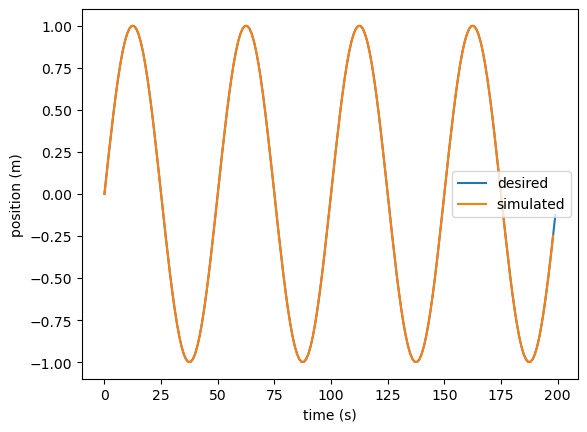

In [124]:
# plot the simulated trajectory and the desired trajectory
plt.figure()
plt.plot(y_des)
plt.plot(y_traj_pos)
plt.legend(['desired','simulated'])
plt.xlabel('time (s)')
plt.ylabel('position (m)')

plt.show()

### Exercise 3.3: 
Suppose that the mass of the system is not exactly known and that the true mass is 0.9 times the previous mass. Create a new system with this true mass and compute y_traj_real.

In [125]:
y_traj_real_pos = []
m_new = 0.9

#Your code here
# get the velocity by integrating the Newton law 
y_velocity = []
for i in range(199):
    if i==0:
        integral = 0
    elif i == 1:
        integral = Ts*u_traj_ff[0][0][0]
    else:
        a = 0
        b = i
        integral = 0
        for j in range(i):
            integral += Ts*u_traj_ff[j][0][0]
    
    integral = integral/m_new
    
    y_velocity.append(integral)

In [126]:
#get back the position from the velocity
for i in range(1, 199):
    if i==1:
        y_traj_real_pos.append(y_velocity[i-1]*Ts)
    else:
        y_traj_real_pos.append(y_velocity[i-1]*Ts + y_traj_real_pos[-1])

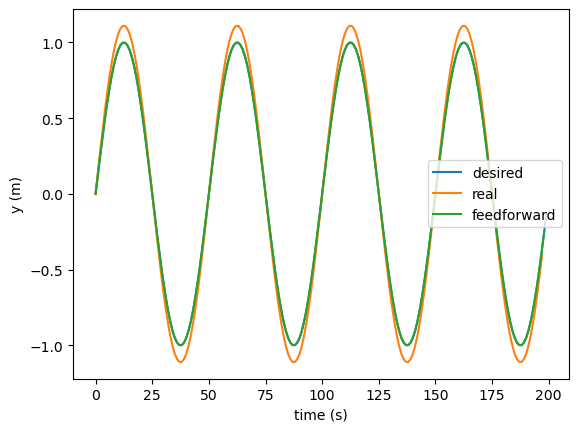

In [127]:
plt.figure()
plt.plot(y_des)
plt.plot(y_traj_real_pos)
plt.plot(y_traj_pos)
plt.legend(['desired','real','feedforward'])
plt.xlabel('time (s)')
plt.ylabel('y (m)')
plt.show()

## Feedback control

It is clear from the previous plot that the feedforward control is not enough to track the desired trajectory in the presence of noise, model errors and disturbances. We need a negative feedback loop that measures the error between the desired trajectory and the real trajectory and uses it to reduce tracking errors. Negative feedback loops, being widely and frequently used, are nearly synonymous with the field of control.

<img src="tp3/media/FB.png" alt="Feedback control system" width="500"/>

For LTI systems, a common form of negative feedback is the linear state feedback law 

$u = K (x_\mathrm{des} - x)$.

If the control task involves taking the system to the origin ($x_\mathrm{des} = 0$),the closed-loop system is then described by the following discrete-time LTI system:

$x_{k+1} = (A - BK)x_k$

$y_k = Cx_k$

### Exercise 3.4
For the point-mass system, design a state feedback controller for tracking the desired trajectory. Use zero for the desired velocity. (Hint: The design involves guessing the matrix K.)

Additional info: We are implementing a proportional-derivative (PD) controller. The first term of K acting on the position error, is the proportional controller gain, while the second term of K, acting on the velocity error, is the derivative error controller.

In [13]:
print(y_des.shape)
x_des = np.vstack([y_des,y_des*0])
x_des

(200,)


array([[ 0.00000000e+00,  1.25333234e-01,  2.48689887e-01,
         3.68124553e-01,  4.81753674e-01,  5.87785252e-01,
         6.84547106e-01,  7.70513243e-01,  8.44327926e-01,
         9.04827052e-01,  9.51056516e-01,  9.82287251e-01,
         9.98026728e-01,  9.98026728e-01,  9.82287251e-01,
         9.51056516e-01,  9.04827052e-01,  8.44327926e-01,
         7.70513243e-01,  6.84547106e-01,  5.87785252e-01,
         4.81753674e-01,  3.68124553e-01,  2.48689887e-01,
         1.25333234e-01,  1.22464680e-16, -1.25333234e-01,
        -2.48689887e-01, -3.68124553e-01, -4.81753674e-01,
        -5.87785252e-01, -6.84547106e-01, -7.70513243e-01,
        -8.44327926e-01, -9.04827052e-01, -9.51056516e-01,
        -9.82287251e-01, -9.98026728e-01, -9.98026728e-01,
        -9.82287251e-01, -9.51056516e-01, -9.04827052e-01,
        -8.44327926e-01, -7.70513243e-01, -6.84547106e-01,
        -5.87785252e-01, -4.81753674e-01, -3.68124553e-01,
        -2.48689887e-01, -1.25333234e-01, -2.44929360e-1

In [84]:
m = 1

In [146]:
y_traj_fb = []
x_traj_fb = []
x_traj_fb.append(x0)

x_des = np.vstack([y_des,y_des*0])

omega = 1/(2*np.pi/50)*8
xi = 0.26*2

Kp = m*omega**2
Kd = 2*m*omega*xi

K = np.array([[Kp, Kd]]) # Add your feedback gains here

LTI_fb = LTI_system(np.array([[1, Ts], [0, 1]]), np.array([[0], [Ts/m_new]]), np.array([1, 0]).reshape(1,2))

u_traj_fb = []
for i in range(199):
    # Add your code here
    u = K @ (x_des[:,i+1] - x_traj_fb[-1].ravel())
    u = np.array([u])
    u_traj_fb.append(u)
    
    x_step, y_step = LTI_fb.simulate(x_traj_fb[-1], u)

    y_traj_fb.append(y_step)
    x_traj_fb.append(x_step)
    
y_traj_fb = np.array(y_traj_fb).reshape(199)

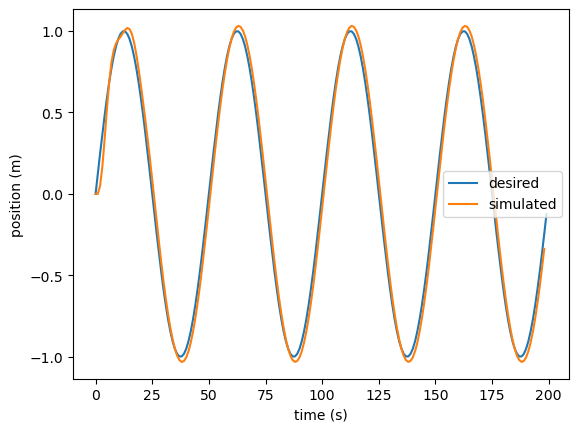

In [132]:
# Plot state tracking
plt.figure()
plt.plot(y_des)
plt.plot(y_traj_fb)
plt.legend(['desired','simulated'])
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.show()

## Exercise 3.5
Suppose that the system also has noisy dynamics. Add Gaussian noise to the x_step output of the LTI system. Simulate the system you designed in Ex 3.4. What can you say about its behavior and how the magnitude of $K$ affects tracking in noisy systems.

In [142]:
y_traj_fb = []
x_traj_fb = []
x_traj_fb.append(x0)

x_des = np.vstack([y_des,y_des*0])

omega = 1/(2*np.pi/50)*8
xi = 0.26*2

Kp = m*omega**2
Kd = 2*m*omega*xi

K = np.array([[Kp, Kd]]) # Add your feedback gains here

LTI_fb = LTI_system(np.array([[1, Ts], [0, 1]]), np.array([[0], [Ts/m_new]]), np.array([1, 0]).reshape(1,2))

u_traj_fb = []
for i in range(199):
    # Add your code here
    u = K @ (x_des[:,i+1] - x_traj_fb[-1].ravel())
    u = np.array([u])
    u_traj_fb.append(u)
    
    x_step, y_step = LTI_fb.simulate(x_traj_fb[-1], u)
    x_step += np.random.normal(0,1/4, (2,1))              #add gaussian noise to x_step output of the LTI system

    y_traj_fb.append(y_step)
    x_traj_fb.append(x_step)
    
y_traj_fb = np.array(y_traj_fb).reshape(199)

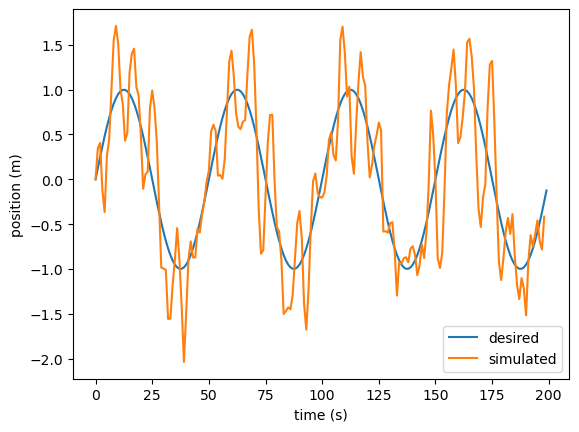

In [143]:
# Plot state tracking
plt.figure()
plt.plot(y_des)
plt.plot(y_traj_fb)
plt.legend(['desired','simulated'])
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.show()

Answer to the question : 

Superior tracking often requires both feedforward and feedback control as shown in 

<img src="tp3/media/FF_FB.png" alt="Feedback control system" width="700"/>

Feedforward terms permit tracking complex trajectories using the knowledge of system dynamics while the feedback terms stabilize the system around the desired setpoint.

### Exercise 3.6
Combine the feedback and feedforward actions to track the desired trajectory for the point mass system from Exercise 3.3.

In [185]:
y_traj_fbff = []
x_traj_fbff = []
u_traj = []
u_traj_ff = []
x_traj_fbff.append(x0)

LTI_fbff = LTI_system(np.array([[1, Ts], [0, 1]]), np.array([[0], [Ts/m_new]]), np.array([0, 1]).reshape(1,2))

for i in range(199):
    x_err = x_des[:,i] - x_traj_fbff[i].ravel() 
    u_traj_ff.append(1/(LTI_fbff.C @ LTI_fbff.B) * (- LTI_fbff.C @ LTI_fbff.A @ (x_traj_fbff[-1])))
    u = K @ x_err + u_traj_ff[i]
    u_traj.append(u)
    x_step, _ = LTI_fbff.simulate(x_traj_fbff[-1], u_traj[-1])
    x_traj_fbff.append(x_step)
    y_traj_fbff.append(LTI_fbff.output(x_step  + np.random.normal(0,1/4, (2,1)), u_traj[-1]))
    
y_traj_fbff = np.array([y_traj_fbff]).reshape(199)

In [186]:
#get back the position from the velocity
y_traj_fbff_pos = []
for i in range(1, 199):
    if i==1:
        y_traj_fbff_pos.append(y_traj_fbff[i-1]*Ts)
    else:
        y_traj_fbff_pos.append(y_traj_fbff[i-1]*Ts + y_traj_fbff_pos[-1])

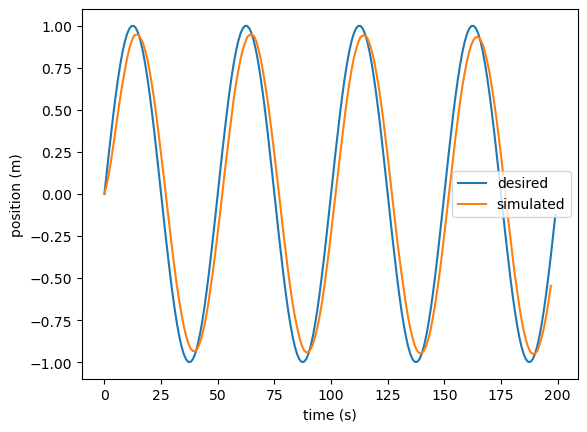

In [187]:
# plot the simulated trajectory and the desired trajectory

plt.figure()
plt.plot(y_des)
plt.plot(y_traj_fbff_pos)
plt.legend(['desired','simulated'])
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.show()

## System stability

Let us consider regulation problem, where the desired trajectory being tracked is a fixed set-point. Without loss of generality (why?) for regulation problems, we can assume that we want the system to reach the origin. 

It is important to characterize the stability of the feedback system, as it is a property that implies 'good behavior' of the closed-loop system, i.e. that it will not diverge or oscillate from the desired set-point.  Unstable systems can be dangerous in practice. 

The stability of closed-loop LTI systems can be straightforwardly characterized using the eigenvalues of the closed-loop system matrix $A_\mathrm{cl} = A - B K$. The magnitude of all the eigenvalues of the matrix A - B*K should be less than 1.0. For LTI systems, this is equivalent to checking that the system is stable. If one of the eigenvalues has a magnitude equal to 1, the system is said to be marginally stable. Note that since 

$x_{k+1} = A_\mathrm{cl} x_k$,

### Exercise 3.7 

Compute the eigenvalues of the point-mass system and the closed-loop system with the linear feedback gains chosen in Exercise 3.4 and characterize the stability property of these two systems.

In [188]:
omega = 1/(2*np.pi/50)*8
xi = 0.26*2

Kp = m*omega**2
Kd = 2*m*omega*xi

K = np.array([[Kp, Kd]]) # Add your feedback gains here

A = np.array([[1, Ts], [0, 1]])
B = np.array([[0], [Ts/m_new]])

Ac = A - B @ K

In [190]:
eigenvalues, eigenvectors = np.linalg.eig(Ac)

In [200]:
abs(eigenvalues)

array([0.86209058, 0.86209058])

Answer: All the magnitude of the eigenvalues of the Matrix $A_c$ are strictly less than 1, then the LTI system of the question 3.4 is is said to be strictly stable

While it was fairly straightforward to guess stable feedback gains for the point mass system, this is not so easy for more complex systems with higher dimensions. Fortunately, there exist several methods to compute these gains. One of the most popular methods is Linear Quadratic Regulator (LQR). LQR is a method that minimizes the cost function, (assuming that the system is being stabilized around the origin):

$J = \sum_{t=0}^{T} (x_t^T Q x_t + u_t^T R u_t)$,
where $Q$ and $R$ are positive definite matrices. The LQR controller is the optimal feedback gain that minimizes this cost function. The LQR controller can be computed using the following steps:

 1. Solve the discrete-time Riccati equation for the system:
 
    $ P = A^T P A - A^T P B (B^T P B + R)^{-1} B^T P A + Q $ 

2. Compute feedback gain

    $K = (R + B^T P B)^{-1} B^T P A$

3. The control law is then:
    
    $ u = -K x $

LQR (and linear control in general) is a useful tool even for controlling nonlinear systems. Nonlinear systems are often locally linearizable, using their first derivatives. The controller design is then performed for this linearized system and can be effective as long as the nonlinear system remains close to the linearization point.

In this exercise, we will consider the nonlinear system cart-pole, linearized around the upright position. The state of the system is 

$x = \begin{bmatrix} x \\ \theta \\ \dot{x} \\ \dot{\theta} \end{bmatrix}$.

The system dynamics and the linearization around the upright position can be found in 
https://courses.ece.ucsb.edu/ECE594/594D_W10Byl/hw/cartpole_eom.pdf

Assume that $M = 0$, $m_p = 1$ and $L = 1$.

### Exercise 3.8

Compute the LQR feedback gains for the cart-pole system linearized at the upright position. Stabilize the system at the upright position the LQR controller, starting from a state close to the upright position. Simulate the nonlinear system for 10 seconds and plot the state trajectories.

(Hint: use scipy.linalg.solve_discrete_are to solve the Riccati equation)

In [209]:
g = 9.81
M = 1
m = 1
l = 1


C = np.array([[0,1,0,0],[0,0,0,1]])
## Code goes here to compute the feedback gains K 

In [259]:
A = Ts*np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, m*g/M, 0, 0], [0, (M+m)/M*(g/l), 0, 0]]) + np.eye(4)
B = Ts*np.array([[0], [0], [1/M], [1/M*l]])
Q = np.diag(1.5*np.ones(4))
R = np.diag(np.ones(1))

In [260]:
P = solve_discrete_are(A, B, Q, R)
K = inv(R + B.T @ P @ B) @ B.T @ P @ A

In [261]:
# nonlinear system, Forward Euler
def nls_cartpole(x,u, Ts):
    M = 1
    m = 1
    l = 1
    xcdot = x[1]
    thetadot = x[3]
    xc = x[0]
    theta = x[2]
    s = np.sin(theta)
    c = np.cos(theta)
    u = np.clip(u, -5, 5)
    xcddot = (-s*(m*l)*c*thetadot**2 + s*m*c*g + u)/(-m*c**2 + M + m)
    thetaddot = (-s*(m*l)*c*thetadot**2 + s*g*(M+m) + u*c)/(l*(-m*c**2 + M + m))
    xc = xc + Ts*xcdot
    xcdot = xcdot + Ts*xcddot
    theta = theta + Ts*thetadot
    thetadot = thetadot + Ts*thetaddot
    return np.hstack([xc,xcdot,theta,thetadot])

In [266]:
Nsteps = 1000
# simulate the system
x0 = np.array([0,0,0.1,0])
x_traj = []
x_traj.append(x0)
u_traj = []
y_traj = []
y_traj.append(C @ x0)
for i in range(Nsteps):
    u = -K @ x_traj[-1]
    x_step = nls_cartpole(x_traj[-1],u,Ts)
    x_traj.append(x_step)
    y_traj.append(C @ x_step)
    u_traj.append(u)

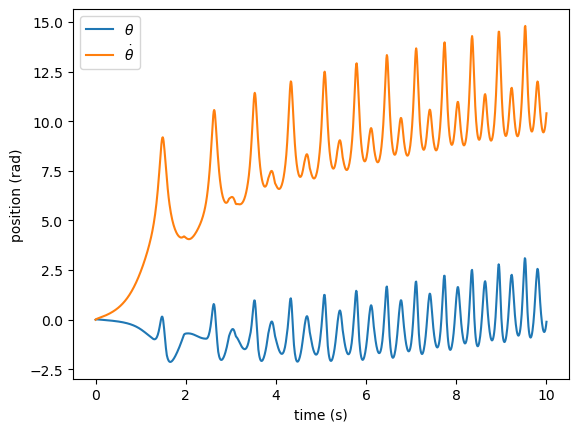

In [267]:
# plot the simulated trajectory and the desired trajectory
plt.figure()
plt.plot(np.linspace(0,Nsteps*Ts,Nsteps+1),[y[0] for y in y_traj])
plt.plot(np.linspace(0,Nsteps*Ts,Nsteps+1),[y[1] for y in y_traj])
plt.legend(['$\\theta$','$\\dot{\\theta}$'])
plt.xlabel('time (s)')
plt.ylabel('position (rad)')
plt.show()

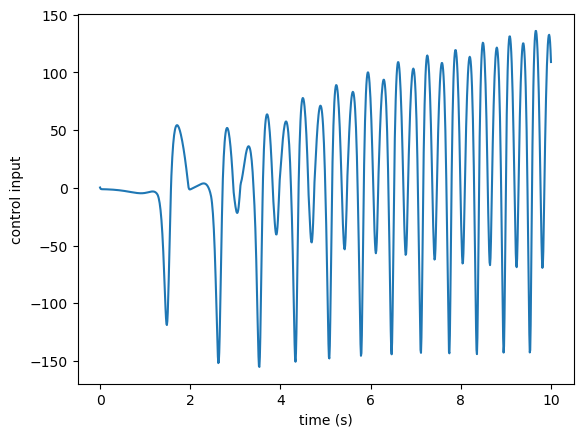

In [268]:
# plot the control input
plt.figure()
plt.plot(np.linspace(0,Nsteps*Ts,Nsteps),u_traj)
plt.xlabel('time (s)')
plt.ylabel('control input')
plt.show()

## Bonus question (coming)

Let us setup a robot system that takes joint velocities as inputs and provides EE positions as the output. (EE=endeffector)

In [248]:
class Robot:

    def __init__(self, robotname, q0, ee_name, Ts = 0.01):
        self.robot = robex.load(robotname)
        self.x = q0
        self.ee_id = self.robot.model.getFrameId(ee_name)
        self.Ts = Ts

    def fk_ee(self, q = None):
        if q is None:
            q = self.x
        robot = self.robot
        pin.framesForwardKinematics(robot.model, robot.data, q)
        return self.robot.data.oMf[self.ee_id]
    
    def apply_input(self, u, noise = 'normal'):
        if noise == 'normal':
            u += np.random.normal(0, 0.1, 6)*self.Ts
        self.x = pin.integrate(self.robot.model, self.x, u*self.Ts)
        
        return self.fk_ee(self.x)
    

q0 = np.array([0, -1.5, 1.5, 0, 0, 0])
robot = Robot('ur5', q0, 'tool0')

viz = MeshcatVisualizer(robot.robot)
viz.display(robot.x)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [272]:
robot.fk_ee()

#robot.ee_id

  R =
          -1 -9.79328e-12  4.79542e-23
           0  4.89664e-12            1
-9.79328e-12            1 -4.89664e-12
  p = 0.422313  0.19145 0.418444

Let $$p(t) = \mathrm{fk_{ee}}(q(t))$$ be the end-effector position at time $t$.